# Previsão de Séries Temporais com o Prophet

## O Problema de um Abrigo de Animais

O Centro de animais de Austin, no Texas, provê abriga para mais de 16 mil animais por ano, além de outros serviços envolvendo proteção de animais - independente da raça, idade ou estado de saúde desses.

Tendo como principal objetivo "destinar todos os animais possíveis para um novo lar, seja por meio de adoção, assistência social ou grupos de resgate.

Apesar desse objetivo, não é possível conseguir um lar para todos esse animais, e muitos acabam sendo sacrificados. A meta do Austin Animal Center é conseguir que o desfecho positivo, ou seja a saída com vida desses animais, seja superior a 90% do total.

Neste projeto, iremos analisar as saídas com vida desses animais. Com essa análise, espera-se que sejamos capazes de identificar um padrão de adoção.

Mais que identificar um padrão, espera-se fazer previsões futuras em relação ao número de saídado Austin Animal Center, visando:

1. Planejar compras de insumos (remédios, comida, etc);
2. Contratação de funcionários e colaboradores; e
3. Fazer campanhas visando otimizar a adoção de animais.

### Aquisição dos Dados

Os dados foram disponibilizados pelo [Austin Animal Center](http://www.austintexas.gov/content/austin-animal-center) e podem ser baixados diretamente no [City of Austin Open Data Portal](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238).

O *dataset* usado neste *notebook* foi atualizado em 30 de abril de 2020 e contém **117K linhas** e **12 colunas**, onde  

In [ ]:
# importar as bibliotecas necessárias
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# configurar a visualização
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
# importar os dados para um DataFrame
df = pd.read_csv("https://github.com/carlosfab/escola-data-science/blob/master/datasets/shelter_animal_outcomes.csv?raw=true")

# converter a coluna DateTime para o formato conveniente
df.DateTime = pd.to_datetime(df.DateTime)

# ver as primeiras 5 entradas
df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,2019-05-08 18:20:00,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A720371,Moose,2016-02-13 17:59:00,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
3,A674754,NaN,2014-03-18 11:47:00,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
4,A689724,*Donatello,2014-10-18 18:52:00,10/18/2014 06:52:00 PM,08/01/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black


In [ ]:
# ver o resumo das principais informações estatísticas
df.describe()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
count,117416,80599,117416,117416,117416,117408,53247,117416,117413,117369,117416,117416
unique,104978,18867,96710,96710,6806,9,22,5,5,50,2568,585
top,A721033,Max,2016-04-18 00:00:00,04/18/2016 12:00:00 AM,09/01/2015,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,33,525,39,39,117,51722,29119,66777,41234,21150,30746,12337
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2020-04-30 18:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# ver um resumo dos tipos de variáveis e valores não-nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117416 entries, 0 to 117415
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         117416 non-null  object        
 1   Name              80599 non-null   object        
 2   DateTime          117416 non-null  datetime64[ns]
 3   MonthYear         117416 non-null  object        
 4   Date of Birth     117416 non-null  object        
 5   Outcome Type      117408 non-null  object        
 6   Outcome Subtype   53247 non-null   object        
 7   Animal Type       117416 non-null  object        
 8   Sex upon Outcome  117413 non-null  object        
 9   Age upon Outcome  117369 non-null  object        
 10  Breed             117416 non-null  object        
 11  Color             117416 non-null  object        
dtypes: datetime64[ns](1), object(11)
memory usage: 10.7+ MB


In [ ]:
# verificar se há dados ausentes
df.isnull().sum()

Animal ID               0
Name                36817
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type            8
Outcome Subtype     64169
Animal Type             0
Sex upon Outcome        3
Age upon Outcome       47
Breed                   0
Color                   0
dtype: int64

In [ ]:
# ver os tipos de outcomes possíveis
df['Outcome Type'].value_counts()

Adoption           51722
Transfer           34892
Return to Owner    20636
Euthanasia          7890
Died                1075
Rto-Adopt            611
Disposal             495
Missing               67
Relocate              20
Name: Outcome Type, dtype: int64

In [ ]:
# Ver apenas os outcomes de adoção e retorno aos donos
adoptions_df = df[(df['Outcome Type'] == 'Adoption')]
adoptions_df['outcomeCount'] = 1

adoptions_df = adoptions_df[['DateTime', 'outcomeCount']]
adoptions_df = adoptions_df.set_index('DateTime').sort_index()
adoptions_df.head()

,outcomeCount
DateTime,
2013-10-01 09:31:00,1
2013-10-01 11:42:00,1
2013-10-01 11:53:00,1
2013-10-01 11:53:00,1
2013-10-01 15:47:00,1


In [ ]:
# ver as datas mínimas e máximas
adoptions_df.index.min(), adoptions_df.index.max()

(Timestamp('2013-10-01 09:31:00'), Timestamp('2020-04-30 14:41:00'))

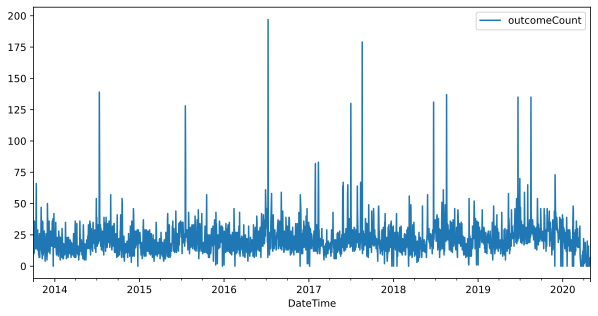

In [ ]:
# plotar gráfico diário
fig, ax = plt.subplots(figsize=(10,5))
adoptions_df.resample('D').sum().plot(ax=ax)
plt.show()

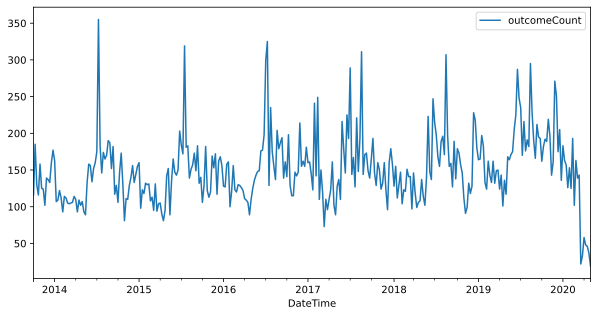

In [ ]:
# plotar gráfico semanal
fig, ax = plt.subplots(figsize=(10,5))
adoptions_df.resample('W').sum().plot(ax=ax)
plt.show()

In [ ]:
# trabalhar com dados diários
prophet_df = adoptions_df.resample('D').sum().reset_index().rename(columns={'DateTime':'ds', 'outcomeCount':'y'})

# ver as 5 primeiras entradas
prophet_df.head()

,ds,y
0,2013-10-01,11
1,2013-10-02,16
2,2013-10-03,10
3,2013-10-04,11
4,2013-10-05,36


### Criar o Modelo de Forecasting

#### Modelo Diário

In [ ]:
# instanciar e treinar o modelo
model = Prophet()
model.add_country_holidays(country_name='US')
model.fit(prophet_df)

# determinar o período de dias para previsão
future = model.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


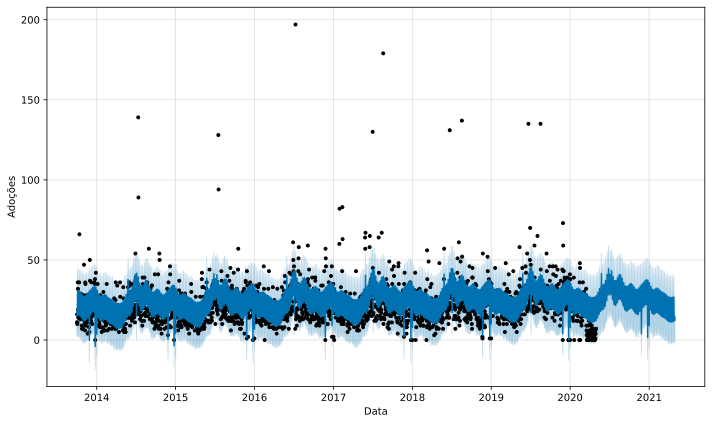

In [ ]:
# visualizar o gráfico com as previsões
model.plot(forecast, xlabel='Data', ylabel='Adoções');

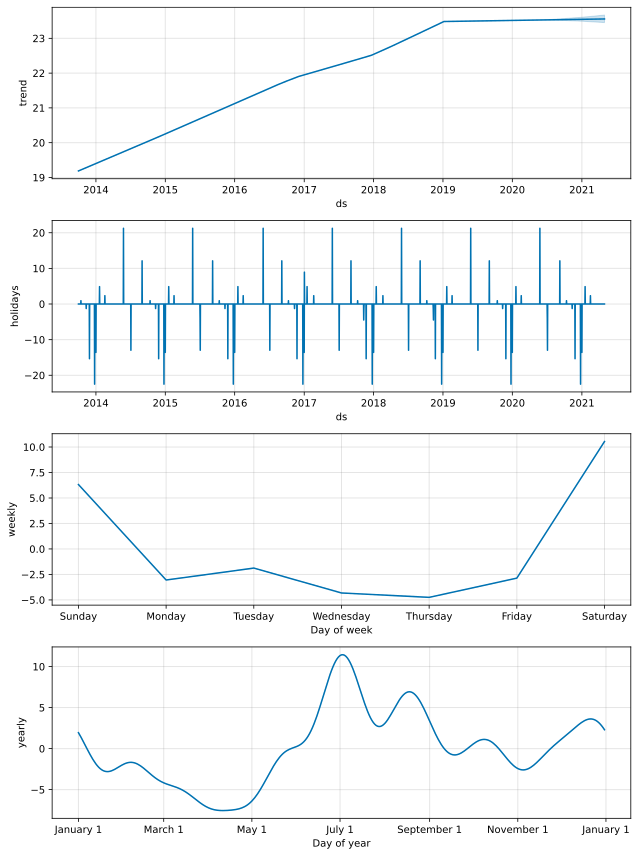

In [ ]:
# separar os componentes do modelo
model.plot_components(forecast);

#### Modelo Semanal

In [ ]:
# criar um modelo baseado em semanas
prophet_df2 = adoptions_df.resample('W').sum().reset_index().rename(columns={'DateTime':'ds', 'outcomeCount':'y'})

# instanciar e treinar o modelo
model2 = Prophet()
model2.add_country_holidays(country_name='US')
model2.fit(prophet_df2)

# determinar o período de dias para previsão
future2 = model2.make_future_dataframe(periods=52)

# realizar a previsão para o período estabelecido
forecast2 = model2.predict(future2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


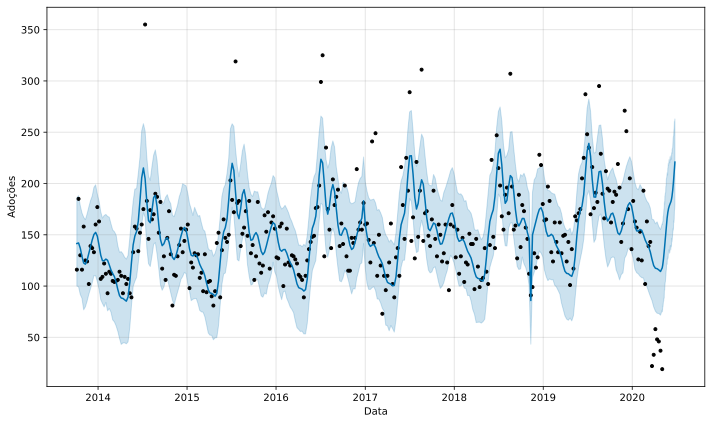

In [ ]:
# visualizar o gráfico com as previsões
model2.plot(forecast2, xlabel='Data', ylabel='Adoções');

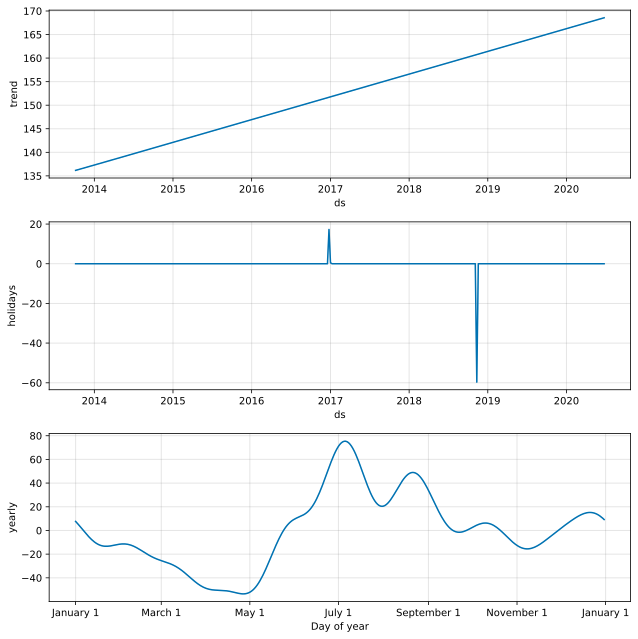

In [ ]:
# separar os componentes do modelo
model2.plot_components(forecast2);

### Avaliação do Modelo de Séries Temporais

#### Modelo Diário

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2016-10-30 12:00:00 and 2019-05-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-10-31,15.600870,3.751543,27.504974,16,2016-10-30 12:00:00
1,2016-11-01,16.126049,4.141427,27.369330,16,2016-10-30 12:00:00
2,2016-11-02,14.074885,2.545649,26.051946,13,2016-10-30 12:00:00
3,2016-11-03,13.698852,1.663784,25.875650,21,2016-10-30 12:00:00
4,2016-11-04,14.618930,3.080519,27.094398,26,2016-10-30 12:00:00


In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,36 days 12:00:00,96.505039,9.823698,7.175719,0.261262,0.853881
1,37 days 00:00:00,96.386036,9.817639,7.161931,0.261262,0.853881
2,37 days 12:00:00,97.327010,9.865445,7.253482,0.266068,0.853881
3,38 days 00:00:00,96.808560,9.839134,7.234443,0.270625,0.853881
4,38 days 12:00:00,96.440728,9.820424,7.205225,0.266068,0.858447


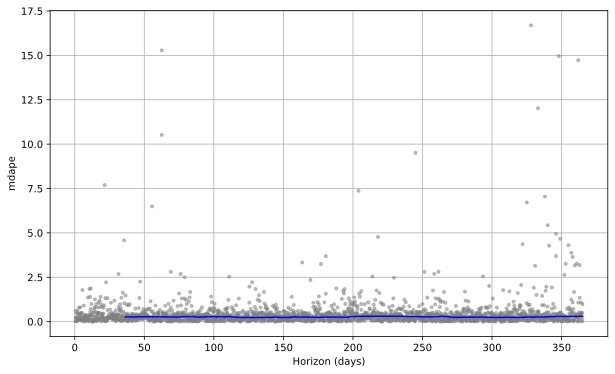

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mdape')

#### Modelo Semanal

INFO:fbprophet:Making 6 forecasts with cutoffs between 2016-11-02 12:00:00 and 2019-05-04 00:00:00



           horizon          mse       rmse  ...      mape     mdape  coverage
0 36 days 00:00:00   965.196674  31.067615  ...  0.185376  0.157142  0.741935
1 36 days 12:00:00   990.868137  31.478058  ...  0.191372  0.165372  0.741935
2 37 days 00:00:00   983.287243  31.357411  ...  0.188472  0.157142  0.741935
3 37 days 12:00:00  1133.772780  33.671543  ...  0.207870  0.165372  0.709677
4 38 days 00:00:00  1140.808037  33.775850  ...  0.209595  0.165372  0.709677

[5 rows x 7 columns] 



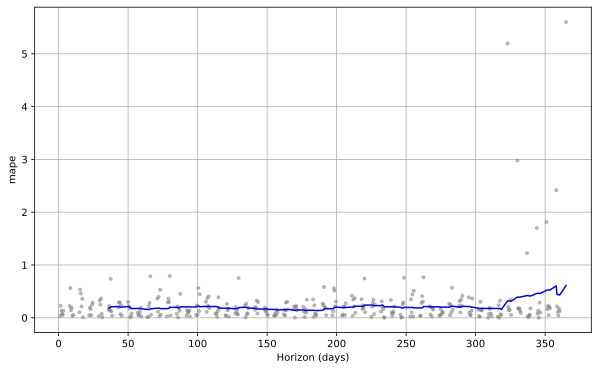

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv2 = cross_validation(model2, horizon = '365 days')
# print(df_cv2.head(), "\n")

from fbprophet.diagnostics import performance_metrics
df_p2 = performance_metrics(df_cv2)
print(df_p2.head(), "\n")

from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv2, metric='mape');

### Feriados e Datas Comemorativas

In [ ]:
# Feriados e datas personalizadas
personalizado = pd.DataFrame({
    'holiday': 'Seu Feriado Aqui',
    'ds': pd.to_datetime(['2018-02-07', '2019-02-07', '2020-02-07']),
    'lower_window': 0,
    'upper_window': 1,
})

model = Prophet(holidays=personalizado)
model.add_country_holidays(country_name='BR')
model.fit(prophet_df)
model.train_holiday_names

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0              Seu Feriado Aqui
1                New Year's Day
2                    Tiradentes
3                  Worker's Day
4              Independence Day
5    Our Lady of the Apparition
6                All Souls' Day
7     Republic Proclamation Day
8                     Christmas
dtype: object

In [ ]:
prophet_df2

,ds,y
0,2013-10-06,116
1,2013-10-13,185
2,2013-10-20,130
3,2013-10-27,116
4,2013-11-03,158
...,...,...
339,2020-04-05,58
340,2020-04-12,48
341,2020-04-19,46
342,2020-04-26,37


In [ ]:
df_p2.mae

0      25.253997
1      26.034585
2      25.867654
3      27.549738
4      27.792434
         ...    
278    29.990434
279    29.531520
280    29.177541
281    28.765467
282    31.945725
Name: mae, Length: 283, dtype: float64